In [1]:
import os
import json
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data
from monai.data import decollate_batch
from functools import partial

import torch


print_config()

MONAI version: 0.8.1+271.g07de215c
Numpy version: 1.24.4
Pytorch version: 2.0.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 07de215caf79dabec20ac53fb38d9f2df36f182a
MONAI __file__: /root/miniconda3/envs/swim/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 10.0.0
Tensorboard version: 1.15.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.59.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.3
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/insta

/root/miniconda3/envs/swim/lib/python3.8/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:568: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  (np.object, string),


In [2]:
def datafold_read(datalist, basedir, fold=0, key="training"):
    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k in d:
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]

    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)

    return tr, val

image shape: (240, 240, 155), label shape: (240, 240, 155)


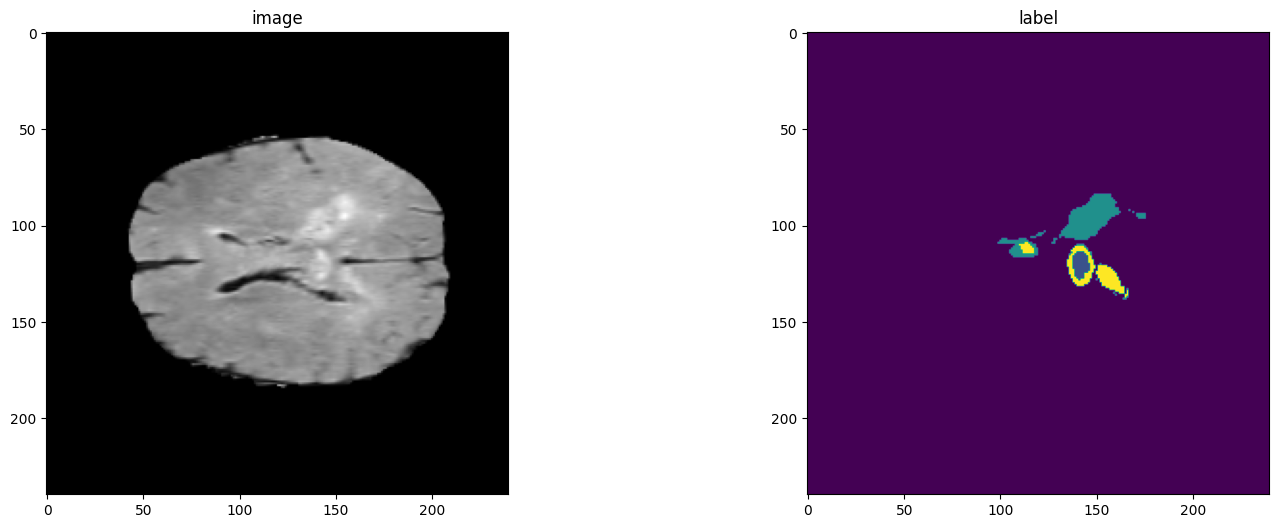

In [3]:
data_dir = "/root/autodl-tmp/BraTs2018/BraTs2018/MICCAI_BraTS_2018_Data_Training/HGG/"
floor = 89
img_add = os.path.join(data_dir, "/root/autodl-tmp/BraTs2018/BraTs2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_2_1/Brats18_2013_2_1_flair.nii")
label_add = os.path.join(data_dir, "/root/autodl-tmp/BraTs2018/BraTs2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_2_1/Brats18_2013_2_1_seg.nii")
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
print(f"image shape: {img.shape}, label shape: {label.shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[:, :, floor], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, floor])
plt.show()

In [4]:
from typing import Tuple
def mask_rand_patch(
    window_sizes: Tuple[int, int, int], input_sizes: Tuple[int, int, int], mask_ratio: float, samples: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor]:
    """Patch-wise random masking."""
    if len(window_sizes) != len(input_sizes) or any(
        [input_size % window_size != 0 for window_size, input_size in zip(window_sizes, input_sizes)]
    ):
        raise ValueError(f"{window_sizes} & {input_sizes} is not compatible.")

    mask_shape = [input_size // window_size for input_size, window_size in zip(input_sizes, window_sizes)]
    num_patches = np.prod(mask_shape).item()
    mask = np.ones(num_patches, dtype=bool)
    indices = np.random.choice(num_patches, round(num_patches * mask_ratio), replace=False)
    mask[indices] = False
    mask = mask.reshape(mask_shape)
    wh, ww, wd = window_sizes
    mask = np.logical_or(mask[:, None, :, None, :, None], np.zeros([1, wh, 1, ww, 1, wd], dtype=bool)).reshape(
        input_sizes
    )
    mask = torch.from_numpy(mask).to(samples.device)

    res = samples.detach().clone()
    res[:, :, mask] = 0
    return res, mask


In [17]:
window_size = 16
roi_x,roi_y,roi_z = 128,128,128
window_sizes = tuple(window_size for _ in range(3))
input_sizes = (roi_x, roi_y, roi_z)
case_num = "2013_2_1"
# /root/autodl-tmp/BraTs2018/BraTs2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_2_1
test_files = [
    {
        "image": [
            os.path.join(
                data_dir,
                "Brats18_" + case_num + "/Brats18_" + case_num + "_flair.nii",
            ),
            os.path.join(
                data_dir,
                "Brats18_" + case_num + "/Brats18_" + case_num + "_t1ce.nii",
            ),
            os.path.join(
                data_dir,
                "Brats18_" + case_num + "/Brats18_" + case_num  + "_t1.nii",
            ),
            os.path.join(
                data_dir,
                "Brats18_" + case_num + "/Brats18_" + case_num + "_t2.nii",
            ),
        ],
        "label": os.path.join(
            data_dir,
            "Brats18_" + case_num + "/Brats18_" + case_num + "_seg.nii",
        ),
    }
]

test_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        transforms.RandSpatialCropd(
                keys=["image", "label"], roi_size=[roi_x, roi_y, roi_z], random_size=False
            ),
    ]
)

test_ds = data.Dataset(data=test_files, transform=test_transform)

test_loader = data.DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

In [37]:
batch_data = next(iter(test_loader))
image = batch_data["image"]
image_masked, mask1 = mask_rand_patch(window_sizes, input_sizes, 0.5, image)
image_masked = image_masked[0]
image = image[0]

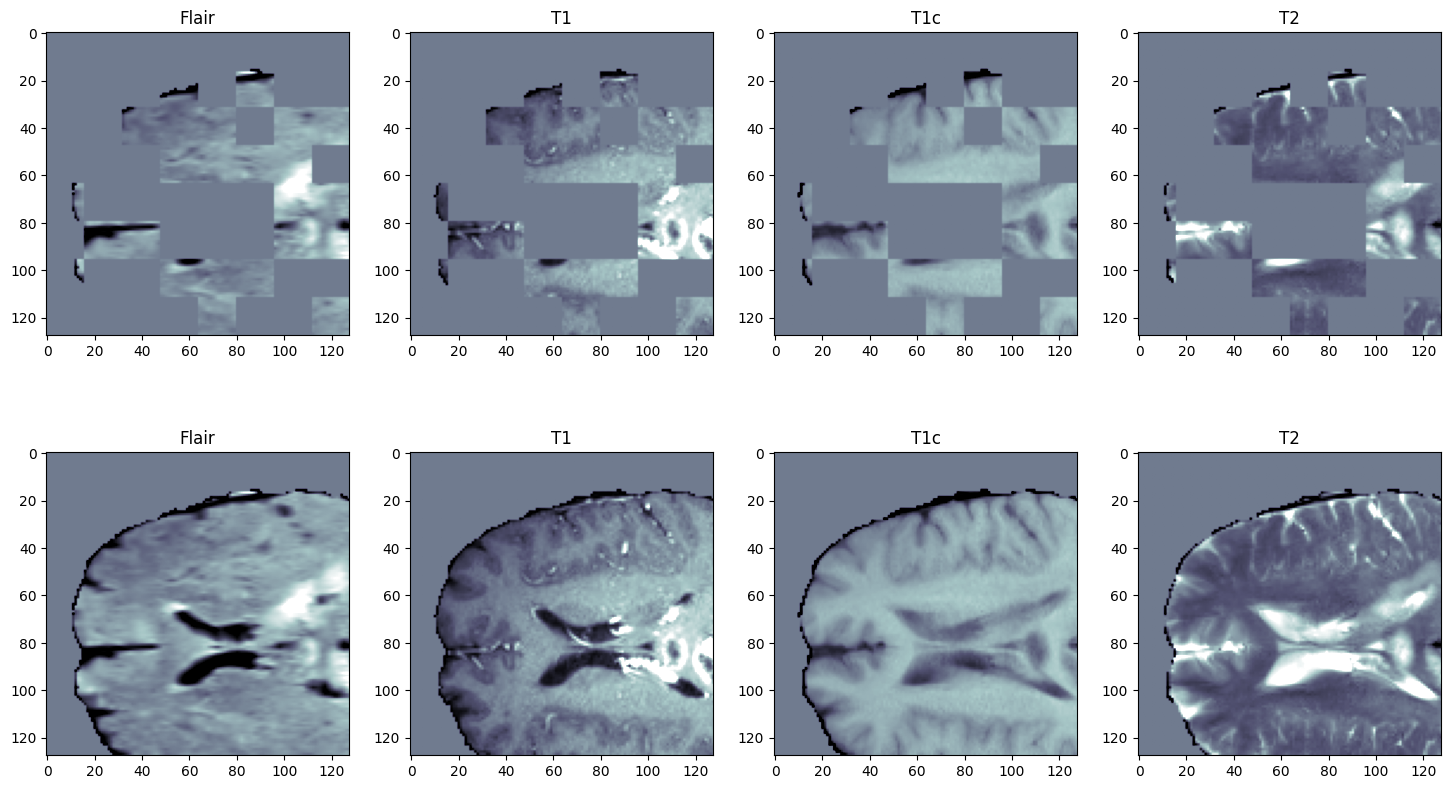

In [50]:

slice_num = 67
plt.figure("image", (18, 10))
plt.subplot(2, 4, 1)
plt.title("Flair")
plt.imshow(image_masked[0,:, :, slice_num], cmap="bone",clim=(-2, 2))
plt.subplot(2, 4, 2)
plt.title("T1")
plt.imshow(image_masked[1,:, :, slice_num], cmap="bone",clim=(-2, 2))
plt.subplot(2, 4, 3)
plt.title("T1c")
plt.imshow(image_masked[2,:, :, slice_num], cmap="bone",clim=(-2, 2))
plt.subplot(2, 4, 4)
plt.title("T2")
plt.imshow(image_masked[3,:, :, slice_num], cmap="bone",clim=(-2, 2))


plt.subplot(2, 4, 5)
plt.title("Flair")
plt.imshow(image[0,:, :, slice_num], cmap="bone",clim=(-2, 2))
plt.subplot(2, 4, 6)
plt.title("T1")
plt.imshow(image[1,:, :, slice_num], cmap="bone",clim=(-2, 2))
plt.subplot(2, 4, 7)
plt.title("T1c")
plt.imshow(image[2,:, :, slice_num], cmap="bone",clim=(-2, 2))
plt.subplot(2, 4, 8)
plt.title("T2")
plt.imshow(image[3,:, :, slice_num], cmap="bone",clim=(-2, 2))


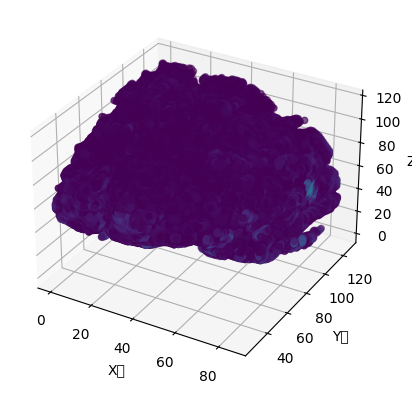

In [29]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()

tumor_data = image[0,0,:,:,:]
# 创建3D坐标轴
ax = fig.add_subplot(111, projection='3d')

# 可视化3D图像数据
x, y, z = np.where(tumor_data > 0)

# 使用scatter绘制散点图来表示肿瘤数据
ax.scatter(x, y, z, c=tumor_data[x, y, z], cmap='viridis', marker='o')

# 设置坐标轴标签
ax.set_xlabel('X轴')
ax.set_ylabel('Y轴')
ax.set_zlabel('Z轴')

# 显示图形
plt.show()